In [ ]:

!pip uninstall -y torch torchvision torchaudio transformers accelerate bitsandbytes


!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


!pip install -q --upgrade transformers datasets accelerate evaluate scikit-learn pandas openpyxl geopy sentence-transformers peft ftfy seaborn matplotlib bitsandbytes country_converter pycountry optuna



In [ ]:
!pip -q install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 11.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re
import time
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    AutoModelForSequenceClassification,
    pipeline,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from tqdm.auto import tqdm
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable, GeocoderServiceError
from sentence_transformers import SentenceTransformer, util
import ftfy
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
import difflib
import optuna


In [ ]:
def clean_text(text: str) :

    try:
        text = ftfy.fix_text(text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE)
        text = re.sub(r'\s+', ' ', text).strip()
    except Exception:
        return ""
    return text

In [ ]:
def get_first_n_sentences(text: str, n: int = 5) :

    sentences = re.split(r'(?<=[.!?])\s+', text)
    return " ".join(sentences[:n])

In [ ]:
train_df = pd.read_excel('final_dataset.xlsx')
train_df['Primary Location'] = train_df['Location']
train_df['Article'] = train_df['Article'].apply(clean_text)
train_df = train_df[['Article','Primary Location']].copy()
train_df["Article"] = train_df["Article"].apply(get_first_n_sentences)
# train_df = train_df.sample(n=200, random_state=42).copy()
train_df.shape

(1008, 2)

In [ ]:
def is_valid_location(location):

    if not location:
        return False


    cleaned = location.replace("-", "").replace("‑", "").replace(".", "").strip()

    return len(cleaned) >= 2 and any(c.isalpha() for c in cleaned)

In [ ]:

ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", device=0,aggregation_strategy="max")

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:


def extract_locations(text: str) :

    try:

        ner_results = ner_pipeline(text)
        locations = []

        for entity in ner_results:
            if entity['entity_group'] == 'LOC':
                location = entity['word'].strip()
                if is_valid_location(location):
                    locations.append(location)

        return list(set(locations))

    except Exception as e:
        print(f"Robust NER extraction failed. Error: {e}")

        return extract_locations(text)

# tqdm.pandas(desc="NER Processing")
# train_df['Candidate_Locations'] = train_df['Article'].progress_apply(extract_locations)
# print("NER candidate extraction complete.")


In [ ]:
train_df.head()

,Article,Primary Location
0,Fatal daytime stabbing shocks Bamenda market d...,"Bamenda, Northwest Region, Cameroon"
1,Rio police seize 800kg of cocaine after shooto...,"Nova Iguaçu, Rio de Janeiro, Brazil"
2,Extortion‑linked arson wave guts San Pedro Sul...,"San Pedro Sula, Cortés Department, Honduras"
3,Chinese engineers abducted from Darfur road pr...,"Nyala, South Darfur, Sudan"
4,Tour bus hijacked outside Acapulco; 18 holiday...,"Acapulco, Guerrero, Mexico"


In [ ]:

embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

geolocator = Nominatim(user_agent="news_location_disambiguation_v1")
location_cache = {}

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def geocode_with_retry(geolocator, query, limit=1, exactly_one=False):

    cache_key = f"{query}_{limit}_{exactly_one}"
    if cache_key in location_cache:
        return location_cache[cache_key]

    for attempt in range(3):
        try:
            time.sleep(1)
            locations = geolocator.geocode(query, language='en', limit=limit, exactly_one=exactly_one)
            location_cache[cache_key] = locations
            return locations
        except (GeocoderTimedOut, GeocoderUnavailable, GeocoderServiceError) as e:

            time.sleep(5 * (attempt + 1))
    location_cache[cache_key] = None
    return None

In [ ]:
def find_containing_sentence(text: str, phrase: str) :

    escaped_phrase = re.escape(phrase)
    pattern = r'\b' + escaped_phrase + r'\b'
    for sentence in re.split(r'(?<=[.!?])\s+', text):
        if re.search(pattern, sentence, re.IGNORECASE):
            return sentence
    return get_first_n_sentences(text, 1)


In [ ]:
def sanitize_location_string(location_str: str):

    if not isinstance(location_str, str):
        return ""

    sanitized = re.sub(r'[^a-zA-Z\s,.-]', '', location_str)

    return re.sub(r'\s+', ' ', sanitized).strip()

In [ ]:
def resolve_toponym(text: str, candidate_str: str):

    if candidate_str is None:
        return None

    containing_sentence = find_containing_sentence(text, candidate_str)
    if not containing_sentence:

        return None


    gazetteer_entries = geocode_with_retry(geolocator, candidate_str, limit=5)
    if not gazetteer_entries or not isinstance(gazetteer_entries, list):
        return None

    try:

        sentence_embedding = embedding_model.encode(containing_sentence, convert_to_tensor=True)
        entry_names = [sanitize_location_string(entry.address) for entry in gazetteer_entries]
        entry_embeddings = embedding_model.encode(entry_names, convert_to_tensor=True)
        semantic_scores = util.cos_sim(sentence_embedding, entry_embeddings)[0].tolist()

        best_candidate = None
        highest_final_score = -1

        W_SEMANTIC = 0.4
        W_GAZETTEER = 0.4
        W_STRING = 0.2

        for i, entry in enumerate(gazetteer_entries):
            gazetteer_score = 1.0 - (i * 0.1)

            string_sim_score = difflib.SequenceMatcher(
                None, candidate_str.lower(), entry.address.split(',')[0].lower()
            ).ratio()

            final_score = (
                (semantic_scores[i] * W_SEMANTIC) +
                (gazetteer_score * W_GAZETTEER) +
                (string_sim_score * W_STRING)
            )

            if final_score > highest_final_score:
                highest_final_score = final_score
                best_candidate = entry

        return best_candidate

    except Exception as e:
        print(f"Error during resolution for '{candidate_str}': {e}")

In [ ]:
def disambiguate_and_create_examples(row):

    article_text = row['Article']
    primary_location_true_str = row['Primary Location']
    ner_candidates = row['Candidate_Locations']
    examples = []
    counter = 0

    primary_coords = geocode_with_retry(geolocator, primary_location_true_str, exactly_one=True)

    if not primary_coords:

        return []


    sanitized_primary_loc = sanitize_location_string(primary_coords.address)
    examples.append({"article": article_text, "location_candidate": sanitized_primary_loc, "label": 1})


    for candidate_str in ner_candidates:
        if not candidate_str or candidate_str.lower() in primary_location_true_str.lower():
            continue

        resolved_location = resolve_toponym(article_text, candidate_str)
        if not resolved_location:
            continue

        distance_km = geodesic(
            (primary_coords.latitude, primary_coords.longitude),
            (resolved_location.latitude, resolved_location.longitude)
        ).kilometers

        if distance_km > 50:
            sanitized_resolved_loc = sanitize_location_string(resolved_location.address)
            examples.append({"article": article_text, "location_candidate": sanitized_resolved_loc, "label": 0})


    return examples




In [ ]:
# all_binary_data = []
# for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Disambiguating Locations"):
#     all_binary_data.extend(disambiguate_and_create_examples(row))

# binary_df = pd.DataFrame(all_binary_data)
# binary_df = binary_df.sample(frac=1, random_state=42).reset_index(drop=True)
# print("Binary classification dataset created with disambiguated locations.")


In [ ]:
binary_df = pd.read_excel("train_dataset_with_NERentries.xlsx")

In [ ]:
print(binary_df.shape)
binary_df.head()

(3269, 3)


,article,location_candidate,label
0,Caracas lops three zeros off bolívar overnight...,"Sabana Grande, Puerto Rico, United States",0
1,Sophisticated burglary ring hits expatriate co...,"Al Narjis, , , Az Zubayr, Al-Zubair Central Su...",0
2,Kharkiv apartment block struck by Russian rock...,"Moscow, Central Federal District, Russia",0
3,Tbilisi's Rustaveli Avenue erupts in massive p...,"Marriott Hotel, Jalan Puri Gejayan, Condongcat...",0
4,College hostel assault sparks outrage after la...,"Global Hospital, Gwarko-Lamatar, Ward , Lalitp...",0


In [ ]:
binary_df.to_excel("binary_dataset.xlsx", index=False)

In [ ]:
train_df.to_excel("candidates_locations.xlsx", index=False)

In [ ]:
binary_df['article'][1]

"Sophisticated burglary ring hits expatriate compounds across Riyadh's northern corridor Before dawn prayers on Sunday, alarms sounded almost simultaneously in three gated communities straddling Riyadh's King Salman Road, an area popular with Canadian oil consultants and Indonesian embassy staff. Less than seven minutes later the thieves were gone, leaving behind pried French doors, empty jewellery cases and footage that has rattled Saudi Arabia's booming expatriate sector. Colonel Turki al‑Shalhoub of the Public Security Directorate said the crew disabled perimeter lasers by spraying canned refrigerant, a technique first documented during robberies in Johannesburg's Sandton district. The gang then exploited a blind spot between CCTV zones to enter villas in Al‑Narjis, Al‑Malqa and the newer Granada Hills compound, carting off high‑end watches, designer handbags and encrypted laptops belonging to an IT subcontractor for the NEOM megaproject. Investigators believe the same syndicate str

# **FINE TUNING DISTILBERT
**

In [ ]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_binary(examples):

    try:
        tokenized = tokenizer(
            examples['article'],
            examples['location_candidate'],
            truncation=True,
            padding="max_length",
            max_length=512
        )

        tokenized['labels'] = examples['label']

        return tokenized

    except Exception as e:
        print(f"Tokenization error: {e}")
        return {"input_ids": [], "attention_mask": [], "labels": []}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
binary_dataset = Dataset.from_pandas(binary_df)
# train_val_split = binary_dataset.train_test_split(test_size=0.3, seed=42)
# tokenized_dataset = train_val_split.map(tokenize_binary, batched=True)
tokenized_dataset = binary_dataset.map(tokenize_binary, batched=True)
tokenized_dataset


Map:   0%|          | 0/3269 [00:00<?, ? examples/s]

Dataset({
    features: ['article', 'location_candidate', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3269
})

\n--- Best Hyperparameters Found ---
{'learning_rate': 3.77211708379645e-05, 'weight_decay': 0.05735545098545671, 'per_device_train_batch_size': 16, 'lora_r': 2048, 'lora_alpha': 2048, 'lora_dropout': 0.046737005089005475}
\nBest F1 Score: 0.8938 **bold text**

In [ ]:
lora_config = LoraConfig(
    r=2048,
    lora_alpha=2048,
    lora_dropout=0.046737005089005475,
    bias="none",
    task_type=TaskType.SEQ_CLS,
    target_modules=["q_lin", "v_lin"],
)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 38,340,866 || all params: 105,295,876 || trainable%: 36.4125


In [ ]:
def compute_metrics(eval_pred):

    try:
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        predictions = np.array(predictions)
        labels = np.array(labels)

        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

        accuracy = accuracy_score(labels, predictions)
        f1 = f1_score(labels, predictions, average="macro")
        precision = precision_score(labels, predictions, average="macro")
        recall = recall_score(labels, predictions, average="macro")

        return {
            "accuracy": accuracy,
            "f1": f1,
            "precision": precision,
            "recall": recall
        }
    except Exception as e:
        print(f"Error in compute_metrics: {e}")
        return {
            "accuracy": 0.0,
            "f1": 0.0,
            "precision": 0.0,
            "recall": 0.0
        }

In [ ]:
training_args = TrainingArguments(
    output_dir="distilbert-lora-location-classifier",
    learning_rate=3.77211708379645e-05,
    num_train_epochs=6,
    per_device_train_batch_size=16,
    eval_strategy="no",
    save_strategy="no",

    logging_strategy="epoch",
    weight_decay=0.05735545098545671,


)

In [ ]:
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset,

)

In [ ]:
trainer.train()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arrameetos11 (arrameetos11-univeristy-of-southampton) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
205,0.573600
410,0.336700
615,0.234600
820,0.167100
1025,0.127600
1230,0.094500


LoRA fine-tuning complete.


# **TEST**

In [ ]:
test_df = pd.read_excel('historic_data_of_risk_alerts_cleaned.xlsx')
test_df.head()

,Article,Primary Location
0,Public Holiday Declared on February 5 for Kash...,Pakistan
1,Deadly Dumper Accidents Claim Five Lives in Ka...,"Karachi, Pakistan"
2,Fatal Collision on Quetta-Karachi Highway Near...,"Quetta- Karachi, Pakistan"
3,BLF Claims Responsibility for Sniper Attack in...,"Kech, Balochistan, Pakistan"
4,"Gunmen Attack Construction Site in Khuzdar, Ba...","Khuzdar, Balochistan, Pakistan"


In [ ]:
print(test_df['Article'][100])
test_df.shape

Suicide Attack on FC Convoy. A female suicide bomber targeted a Frontier Corps (FC) convoy in Kalat city, Balochistan, killing one security personnel and injuring four others. The attack occurred as the FC Commandant was passing through, but he remained unharmed. Authorities have collected the remains of the attacker, and investigations are ongoing.


(614, 2)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Article           614 non-null    object
 1   Primary Location  614 non-null    object
dtypes: object(2)
memory usage: 9.7+ KB


In [ ]:
test_df = test_df[["country","title","where","assessment"]].copy()

In [ ]:
test_df = test_df.dropna(subset=['where'])

In [ ]:
test_df['assessment'] = test_df['assessment'].str.replace('<[^>]+>', '', regex=True)
test_df['Article'] = test_df['title'].fillna('').astype(str) + '. ' + test_df['assessment'].fillna('').astype(str)
test_df['Article']= test_df['Article'].apply(clean_text)
test_df.head()

,country,title,where,assessment
0,Pakistan,Targeted Killing of CIA Officer in Muridke Rai...,"Muridke, Punjab","A Crime Investigation Agency (CIA) officer, Su..."
1,Pakistan,Public Holiday Declared on February 5 for Kash...,Pakistan,"The federal government has declared Wednesday,..."
2,Pakistan,Quetta-Punjab &Khyber Pakhtunkhwa Coach Servic...,Quetta-Punjab & Khyber Pakhtunkhwa,Passenger coach services from Quetta to Punjab...
3,Pakistan,Deadly Dumper Accidents Claim Five Lives in Ka...,Karachi,Karachi witnessed a spike in fatal accidents i...
4,Pakistan,Fatal Collision on Quetta-Karachi Highway Near...,Quetta- Karachi,A high-speed collision involving three cars on...


In [ ]:
test_df['Article'] = test_df['title'].fillna('').astype(str) + '. ' + test_df['assessment'].fillna('').astype(str)

In [ ]:
import re
def check_location_in_assessment(row):

    where_str = str(row['where']) if pd.notna(row['where']) else ''
    article_str = str(row['Article'])

    if not where_str or not article_str:
        return False

    where_words = {word for word in re.split(r'[,\s]+', where_str.lower()) if word}

    if not where_words:
        return True

    for word in where_words:
        if not re.search(r'\b' + re.escape(word) + r'\b', article_str, re.IGNORECASE):
            return False

    return True


rows_to_keep = test_df.apply(check_location_in_assessment, axis=1)


test_df = test_df[rows_to_keep]


print(f"\nNew number of rows: {len(test_df)}")


--- Cleaned DataFrame (irrelevant rows dropped) ---

New number of rows: 821


In [ ]:
def combine_location(row):

    where_str = str(row['where']) if pd.notna(row['where']) else ''
    country_str = str(row['country']) if pd.notna(row['country']) else ''

    if country_str.lower() in where_str.lower():
        return where_str
    else:

        return f"{where_str}, {country_str}".strip(', ')

test_df['Primary Location'] = test_df.apply(combine_location, axis=1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 821 entries, 1 to 1614
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   country           821 non-null    object
 1   title             821 non-null    object
 2   where             821 non-null    object
 3   assessment        821 non-null    object
 4   Article           821 non-null    object
 5   Primary Location  821 non-null    object
dtypes: object(6)
memory usage: 44.9+ KB


In [ ]:
def is_location_resolvable(row):

  location_str = row['Primary Location']
  resolved_location = geocode_with_retry(geolocator, location_str, limit=1, exactly_one=True)

  if resolved_location:
    return True
  else:
    return False

print(f"Number of articles before filtering for resolvable locations: {len(test_df)}")

rows_to_keep = test_df.apply(is_location_resolvable, axis=1)

test_df = test_df[rows_to_keep]

print(f"Number of articles after filtering for resolvable locations: {len(test_df)}")


Number of articles before filtering for resolvable locations: 821


Number of articles after filtering for resolvable locations: 614


In [ ]:
country_counts = test_df['country'].value_counts()

plt.figure(figsize=(6, 6))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')

plt.title('Number of Entries by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [ ]:
pip install country_converter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
import country_converter as coco
test_df['Continent'] = coco.convert(names=test_df['country'], to='continent')

continent_counts = test_df['Continent'].value_counts()



plt.figure(figsize=(8, 8))
plt.pie(continent_counts.values, labels=continent_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Distribution of locations')

plt.axis('equal')

plt.show()

In [ ]:
test_df = test_df[['Article','Primary Location']].copy()
test_df["Article"] = test_df["Article"].apply(get_first_n_sentences)

test_df.head()


,Article,Primary Location
1,Public Holiday Declared on February 5 for Kash...,Pakistan
3,Deadly Dumper Accidents Claim Five Lives in Ka...,"Karachi, Pakistan"
4,Fatal Collision on Quetta-Karachi Highway Near...,"Quetta- Karachi, Pakistan"
10,BLF Claims Responsibility for Sniper Attack in...,"Kech, Balochistan, Pakistan"
11,"Gunmen Attack Construction Site in Khuzdar, Ba...","Khuzdar, Balochistan, Pakistan"


In [ ]:
pip install pycountry

In [ ]:
import pycountry
COUNTRY_NAMES = {country.name.lower() for country in pycountry.countries}

def is_country(location_name: str):
    return location_name.lower() in COUNTRY_NAMES

In [ ]:
classifier_pipeline = pipeline("text-classification", model=lora_model, tokenizer=tokenizer, device=0, top_k=None)

Device set to use cuda:0


In [ ]:
evaluation_results = []
CONFIDENCE_THRESHOLD = 0.70

for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Classifying Test Articles"):
    article = row['Article']
    ner_candidates = extract_locations(article)

    if not ner_candidates:
        continue

    candidates_for_classification = []
    for cand_str in ner_candidates:
        name = sanitize_location_string(cand_str)
        resolved = resolve_toponym(article, name)
        if resolved:
            name = sanitize_location_string(resolved.raw.get('display_name'))
            candidates_for_classification.append({
                "display_name": name,
                "is_country": is_country(name.split(',')[-1].strip())
            })
        else:
            candidates_for_classification.append({
                "display_name": name,
                "is_country": is_country(name)
            })

    if not candidates_for_classification:
        continue

    classifier_inputs = [{"text": article, "text_pair": cand["display_name"]} for cand in candidates_for_classification]
    results = classifier_pipeline(classifier_inputs)

    positive_predictions = []
    for cand, res in zip(candidates_for_classification, results):
        for label_score in res:
            if label_score['label'] == 'LABEL_1':
                positive_predictions.append({
                    "location_name": cand["display_name"],
                    "score": label_score['score'],
                    "is_country": cand["is_country"]
                })
                break

    best_location_name = "NO_PRIMARY_PREDICTED"
    best_score = 0.0
    if positive_predictions:
        specific_locs = sorted([p for p in positive_predictions if not p['is_country']], key=lambda x: x['score'], reverse=True)
        country_locs = sorted([p for p in positive_predictions if p['is_country']], key=lambda x: x['score'], reverse=True)

        if specific_locs and specific_locs[0]['score'] >= CONFIDENCE_THRESHOLD:
            best_location_name = specific_locs[0]['location_name']
            best_score = specific_locs[0]['score']
        elif country_locs:
            best_location_name = country_locs[0]['location_name']
            best_score = country_locs[0]['score']
        elif specific_locs:
            best_location_name = specific_locs[0]['location_name']
            best_score = specific_locs[0]['score']

    evaluation_results.append({
        'Article': article,
        'NER Candidates': ner_candidates,
        'Primary_Location': row['Primary Location'],
        'Predicted_Location': best_location_name,
        'Predicted_Score': best_score
    })

eval_df = pd.DataFrame(evaluation_results)
eval_df.to_excel("final_predictions.xlsx", index=False)
print(f"\nInference complete. {len(eval_df)} articles were processed and saved to 'final_predictions_filtered_fallback.xlsx'.")
print(f"{len(test_df) - len(eval_df)} articles were dropped because NER found no candidates.")



Classifying Test Articles:   0%|          | 0/614 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Inference complete. 605 articles were processed and saved to 'final_predictions_filtered_fallback.xlsx'.
9 articles were dropped because NER found no candidates.


In [ ]:
def check_overlap(string1, list2):
    words = string1.split()

    for word in words:
        for item in list2:
            if word.lower() in item.lower() or item.lower() in word.lower():
                return True
    return False


# true_loc_str = "Ungwan Ate–Ungwan Mission Road in Kachia Local Government Area Kaduna State, Nigeria"
# pred_loc_str = "Kachia Local Government Area"
# true_loc_list = true_loc_str.split(',')
# pred_loc_list = pred_loc_str.split(',')

# print(check_overlap(true_loc_list[0],pred_loc_list))



In [ ]:

detailed_log_data = []

for _, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc="Evaluating Predictions"):
    is_correct = False
    correctness_method = "Incorrect"
    true_location_str = row['Primary_Location']
    pred_location_str = row['Predicted_Location']
    resolved_true_str = ""
    resolved_pred_str = ""
    article = row['Article']


    if "NO_" not in pred_location_str and true_location_str:
        true_coords_result = resolve_toponym(article, true_location_str)
        pred_coords_result = resolve_toponym(article, pred_location_str)





        if true_coords_result and pred_coords_result:
            if geodesic((true_coords_result.latitude, true_coords_result.longitude), (pred_coords_result.latitude, pred_coords_result.longitude)).kilometers <=50:
                is_correct = True
                correctness_method = "distance resolved"


            else:
                true_resolved_str = sanitize_location_string(true_coords_result.raw.get('display_name'))
                pred_resolved_str = sanitize_location_string(pred_coords_result.raw.get('display_name'))
                true_location_list = true_resolved_str.split(',')
                pred_location_list = pred_resolved_str.split(',')

                if check_overlap(true_location_list[0], pred_location_list):
                    is_correct = True
                    correctness_method= "overlap resolved"

        else:
              true_location_list = true_location_str.split(',')
              pred_location_list = pred_location_str.split(',')
              if check_overlap(true_location_list[0], pred_location_list):
                  is_correct = True
                  correctness_method= "overlap not resolved"



    detailed_log_data.append({
            'Article': row['Article'],
            'NER_Extracted_Locations': ", ".join(row['NER Candidates']),
            'True_Location': row['Primary_Location'],
            'Resolved_True_Location': resolved_true_str,
            'Predicted_Location': row['Predicted_Location'],
            'Resolved_Predicted_Location': resolved_pred_str,
            'Predicted_Score': row['Predicted_Score'],
            'Is_Correct': is_correct,
            'Correctness_Method': correctness_method
        })

log_df = pd.DataFrame(detailed_log_data)
log_df.to_excel("evaluation_log.xlsx", index=False)

if not log_df.empty:
    correct_count = log_df['Is_Correct'].sum()
    total_evaluated = len(log_df)
    geographic_accuracy = (correct_count / total_evaluated) * 100

    print(f"\n---Geographic Accuracy Results ---")
    print(f"Accuracy: {geographic_accuracy:.2f}%")
    print(f"({correct_count} correct predictions out of {total_evaluated} evaluable articles)")

    high_confidence_correct = log_df[(log_df['Predicted_Score'] >= 0.8) & (log_df['Is_Correct'] == True)]

    if len(log_df) > 0:
        avg_score = log_df['Predicted_Score'].mean()
        print(f"Average prediction confidence: {avg_score:.3f}")
else:
    print("empty")











--- Calculating Final Geographic Accuracy ---


Evaluating Predictions:   0%|          | 0/605 [00:00<?, ?it/s]


Enhanced evaluation log saved to 'evaluation_log.xlsx'

--- Enhanced Geographic Accuracy Results ---
Accuracy: 87.60%
(530 correct predictions out of 605 evaluable articles)
High confidence (≥0.8) correct predictions: 388
Average prediction confidence: 0.730


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import pandas as pd

ABSTAIN = "ABSTAIN"

def make_label(name: str, article: str) :

    if not name or (isinstance(name, str) and name.startswith("NO_")):
        return ABSTAIN

    try:
        r = resolve_toponym(article, name)
    except Exception:
        r = None

    if r:
        try:
            disp = sanitize_location_string(r.raw.get("display_name", "") or name)
        except Exception:
            disp = sanitize_location_string(name)
        parts = [p.strip() for p in disp.split(",")]
        if len(parts) >= 3:
            return ", ".join(parts[:3])
        elif len(parts) >= 2:
            return ", ".join(parts[:2])
        elif parts:
            return parts[0]
    return sanitize_location_string(name)

y_true_labels = []
y_pred_labels_eval = []

for _, row in log_df.fillna("").iterrows():
    art  = row["Article"]
    y_t  = make_label(str(row["True_Location"]), art)
    y_p0 = make_label(str(row["Predicted_Location"]), art)

    is_correct = bool(row.get("Is_Correct", False))
    y_p = y_t if is_correct else y_p0

    y_true_labels.append(y_t)
    y_pred_labels_eval.append(y_p)

class_labels = sorted({c for c in y_true_labels if c != ABSTAIN})
if not class_labels:
    raise ValueError("No non-ABSTAIN true labels found; cannot compute macro metrics.")

report = classification_report(
    y_true_labels, y_pred_labels_eval,
    labels=class_labels,
    target_names=class_labels,
    output_dict=True,
    zero_division=0
)

overall_accuracy = report.get("accuracy", accuracy_score(y_true_labels, y_pred_labels_eval))
macro_precision  = report["macro avg"]["precision"]
macro_recall     = report["macro avg"]["recall"]
macro_f1         = report["macro avg"]["f1-score"]


print(f"Accuracy:        {overall_accuracy:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro Recall:    {macro_recall:.3f}")
print(f"Macro F1:        {macro_f1:.3f}")

per_class_df = pd.DataFrame(report).T.loc[class_labels, ["precision", "recall", "f1-score", "support"]]
print("\nPer-class metrics :")
print(per_class_df.sort_values("support", ascending=False).head(10).round(3))

per_class_df.to_csv("per_class_location_metrics.csv", index=True)


geo_acc = log_df["Is_Correct"].mean() if len(log_df) else float('nan')
print(f"\nSanity check — Is_Correct mean: {geo_acc:.3f} ")



--- Location Classification Metrics (rule-aligned) ---
Accuracy:        0.876
Macro Precision: 0.856
Macro Recall:    0.841
Macro F1:        0.843

Per-class metrics (top 10 by support):
                                                    precision  recall  \
Pakistan                                                0.952   0.769   
Karachi Division, Sindh, Pakistan                       1.000   1.000   
Baghdad, Green Zone Municipality, Baghdad Gover...      1.000   1.000   
Democratic Republic of the Congo                        1.000   0.786   
Peshawar City Tehsil, Peshawar District, Peshaw...      1.000   0.929   
Quetta City Tehsil, Quetta District, Quetta Div...      1.000   1.000   
Kharkiv Oblast, Ukraine                                 1.000   0.917   
Kharkiv city rada, Kharkiv Raion, Kharkiv Oblast        1.000   1.000   
Afghanistan                                             0.909   1.000   
Islamabad, Zone, Islamabad Capital Territory            1.000   1.000   

        

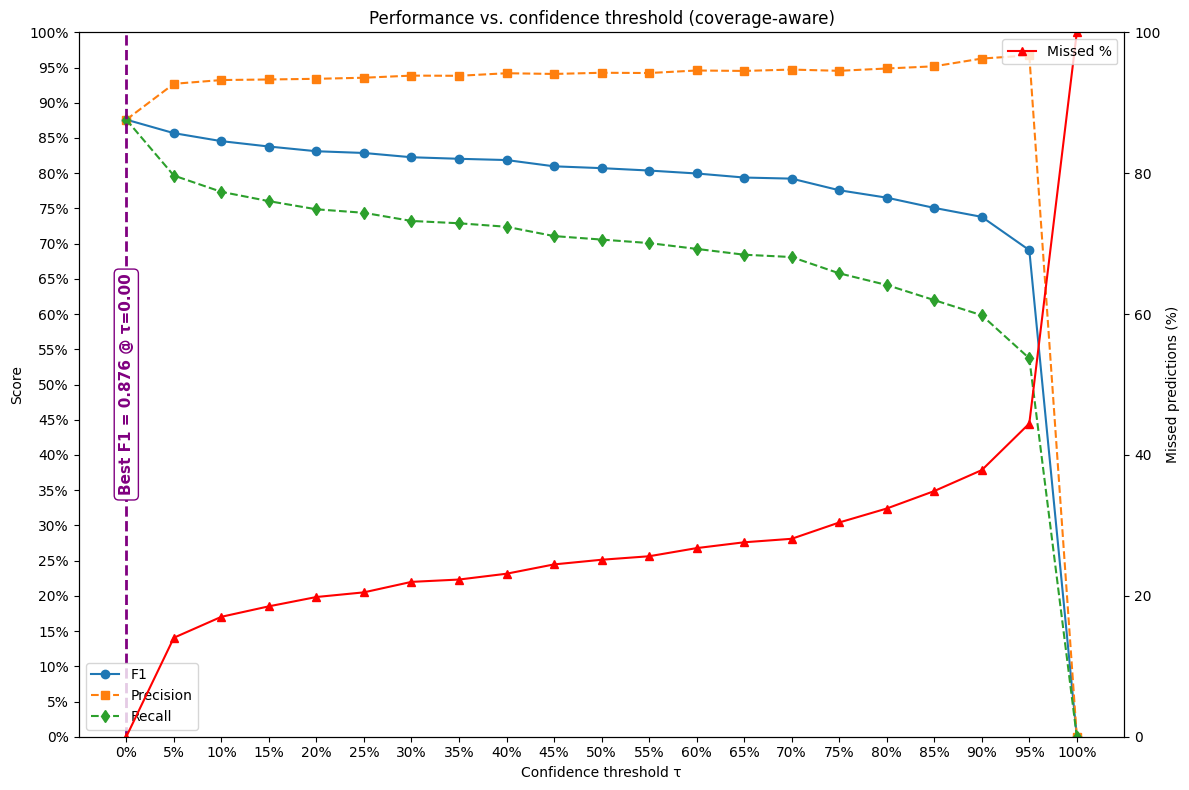

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

df = log_df.copy()
df["Is_Correct"] = df["Is_Correct"].astype(bool)
df["Predicted_Score"] = pd.to_numeric(df["Predicted_Score"], errors="coerce").fillna(0.0)

thresholds = np.arange(0.0, 1.01, 0.05)
N = len(df)

records = []
for τ in thresholds:
    kept_mask = df["Predicted_Score"] >= τ
    kept = kept_mask.sum()
    missed = N - kept

    TP = ((kept_mask) & (df["Is_Correct"] == True)).sum()
    FP = ((kept_mask) & (df["Is_Correct"] == False)).sum()
    FN = N - TP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / N if N > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    records.append({
        "threshold": τ,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "missed_pct": missed / N * 100.0,
        "kept": kept
    })

perf = pd.DataFrame(records)

best_idx = perf["f1"].idxmax()
best_threshold = float(perf.loc[best_idx, "threshold"])
best_f1 = float(perf.loc[best_idx, "f1"])

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(perf.threshold, perf.f1,        "o-", label="F1")
ax1.plot(perf.threshold, perf.precision, "s--", label="Precision")
ax1.plot(perf.threshold, perf.recall,    "d--", label="Recall")
ax1.set_xlabel("Confidence threshold τ")
ax1.set_ylabel("Score")
ax1.set_ylim(0, 1)
ax1.set_xticks(thresholds)
ax1.set_yticks(np.arange(0.0, 1.01, 0.05))
ax1.xaxis.set_major_formatter(PercentFormatter(1.0))
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax1.legend(loc="lower left")

ax1.axvline(best_threshold, color="purple", linestyle="--", linewidth=2)
ymin, ymax = ax1.get_ylim()
y_mid = (ymin + ymax) / 2
ax1.text(best_threshold, y_mid,
         f"Best F1 = {best_f1:.3f} @ τ={best_threshold:.2f}",
         color="purple", rotation=90, ha="center", va="center",
         fontsize=11, fontweight="bold",
         bbox=dict(facecolor="white", edgecolor="purple", boxstyle="round,pad=0.3"))

ax2 = ax1.twinx()
ax2.plot(perf.threshold, perf["missed_pct"], "^-", color="red", label="Missed %")
ax2.set_ylabel("Missed predictions (%)")
ax2.set_ylim(0, 100)
ax2.legend(loc="upper right")

plt.title("Performance vs. confidence threshold (coverage-aware)")
plt.tight_layout()
plt.show()


# **Atrocities dataset**

In [ ]:
atroc_test_df = pd.read_excel('walahi_final_atrocities_dataset.xlsx')
atroc_test_df.head()

,Article,Primary Location,Latitude,Longitude
0,Armed men shot dead the village chief of Chaha...,"Chahar Shanghoy village, Mangajek, Jowzjan, Af...",36.934167,66.113889
1,Two female suicide bombers have killed at leas...,"Kouyape, Kolofata, Far North, Cameroon",11.020833,13.966389
2,At least 15 Agatu farmers were killed in Udeni...,"Udeni Ruwa District, Toto, Nasarawa, Nigeria",8.250000,7.198056
3,At least five persons were killed on Monday [4...,"Izge Gwoza and Izge Dambuwa villages, Gwoza LG...",11.176389,13.579167
4,No fewer than 16 persons have been reportedly ...,"Ula Upata community, Ahoada East LGA, Rivers,...",5.070278,6.642778


In [ ]:
atroc_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Article           646 non-null    object 
 1   Primary Location  646 non-null    object 
 2   Latitude          646 non-null    float64
 3   Longitude         646 non-null    float64
dtypes: float64(2), object(2)
memory usage: 20.3+ KB


In [ ]:
atroc_test_df['Article']= atroc_test_df['Article'].apply(clean_text)

In [ ]:
atroc_test_df["Article"] = atroc_test_df["Article"].apply(get_first_n_sentences)

In [ ]:
atroc_classifier_pipeline = pipeline("text-classification", model=lora_model, tokenizer=tokenizer, device=0, top_k=None)

Device set to use cuda:0


In [ ]:
evaluation_results = []
CONFIDENCE_THRESHOLD = 0.70

for _, row in tqdm(atroc_test_df.iterrows(), total=len(atroc_test_df), desc="Classifying Test Articles"):
    article = row['Article']
    ner_candidates = extract_locations(article)
    latitude = row['Latitude']
    longitude = row['Longitude']

    if not ner_candidates:
        continue

    candidates_for_classification = []
    for cand_str in ner_candidates:
        name = sanitize_location_string(cand_str)
        resolved = resolve_toponym(article, name)
        if resolved:
            name = sanitize_location_string(resolved.raw.get('display_name'))
            candidates_for_classification.append({
                "display_name": name,
                "is_country": is_country(name.split(',')[-1].strip())
            })
        else:
            candidates_for_classification.append({
                "display_name": name,
                "is_country": is_country(name)
            })

    if not candidates_for_classification:
        continue

    classifier_inputs = [{"text": article, "text_pair": cand["display_name"]} for cand in candidates_for_classification]
    results = atroc_classifier_pipeline(classifier_inputs)

    positive_predictions = []
    for cand, res in zip(candidates_for_classification, results):
        for label_score in res:
            if label_score['label'] == 'LABEL_1':
                positive_predictions.append({
                    "location_name": cand["display_name"],
                    "is_country": cand["is_country"]
                })
                break

    best_location_name = "NO_PRIMARY_PREDICTED"
    best_score = 0.0
    if positive_predictions:
        specific_locs = sorted([p for p in positive_predictions if not p['is_country']], key=lambda x: x['score'], reverse=True)
        country_locs = sorted([p for p in positive_predictions if p['is_country']], key=lambda x: x['score'], reverse=True)

        if specific_locs and specific_locs[0]['score'] >= CONFIDENCE_THRESHOLD:
            best_location_name = specific_locs[0]['location_name']
            best_score = specific_locs[0]['score']
        elif country_locs:
            best_location_name = country_locs[0]['location_name']
            best_score = country_locs[0]['score']
        elif specific_locs:
            best_location_name = specific_locs[0]['location_name']
            best_score = specific_locs[0]['score']
    evaluation_results.append({
        'Article': article,
        'NER Candidates': ner_candidates,
        'Primary Location': row['Primary Location'],
        'Predicted_Location': best_location_name,
        'Predicted_Score': best_score,
        'Latitude': latitude,
        'Longitude': longitude,
    })

eval_df = pd.DataFrame(evaluation_results)
eval_df.to_excel("final_predictions.xlsx", index=False)
print(f"{len(atroc_test_df) - len(eval_df)} articles were dropped because NER found no candidates.")



Classifying Test Articles:   0%|          | 0/646 [00:00<?, ?it/s]


Inference complete. 643 articles were processed and saved to 'final_predictions_filtered_fallback.xlsx'.
3 articles were dropped because NER found no candidates.


In [ ]:
eval_df.head()

,Article,NER Candidates,Primary Location,Predicted_Location,Predicted_Score,Latitude,Longitude
0,Armed men shot dead the village chief of Chaha...,"[Mangajek District, Chahar Shanghoy, Jowzjan P...","Chahar Shanghoy village, Mangajek, Jowzjan, Af...","Jowzjan Province, Afghanistan",0.023254,36.934167,66.113889
1,Two female suicide bombers have killed at leas...,"[Nigeria, Cameroon, Kouyape, Kolofata]","Kouyape, Kolofata, Far North, Cameroon","Kouyap, Kolofata, Mayo-Sava, Far-North, Cameroon",0.109106,11.020833,13.966389
2,At least 15 Agatu farmers were killed in Udeni...,"[Nasarawa State, Udeni Ruwa, Toto Local Govern...","Udeni Ruwa District, Toto, Nasarawa, Nigeria",Udeni Ruwa,0.702862,8.250000,7.198056
3,At least five persons were killed on Monday [4...,"[Borno State, Gwoza, Izge Dambuwa, Izge Gwoza]","Izge Gwoza and Izge Dambuwa villages, Gwoza LG...","Bita Izge, Gwoza, Borno State, Nigeria",0.995316,11.176389,13.579167
4,No fewer than 16 persons have been reportedly ...,"[Ula Upata, Ahoada East Local Government Area,...","Ula Upata community, Ahoada East LGA, Rivers,...","Rivers State, Nigeria",0.009712,5.070278,6.642778


In [ ]:
detailed_log_data = []

for _, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc="Evaluating Predictions"):
    is_correct = False
    correctness_method = "Incorrect"
    true_location_str = row['Primary Location']
    # print("type of true_loc_str: ",type(true_location_str)," with value: ", true_location_str)
    pred_location_str = row['Predicted_Location']
    # print("type of pred_loc_str: ",type(pred_location_str)," with value: ", pred_location_str)
    resolved_true_str = ""
    resolved_pred_str = ""
    article = row['Article']
    latitude = row['Latitude']
    longitude = row['Longitude']



    if "NO_" not in pred_location_str and true_location_str:
        # true_coords_result = resolve_toponym(article, true_location_str)
        pred_coords_result = resolve_toponym(article, pred_location_str)
        # print("true_coords result:", true_coords_result)
        # print("predicted_coords result: ",pred_coords_result)




        if pred_coords_result:
            if geodesic((latitude, longitude), (pred_coords_result.latitude, pred_coords_result.longitude)).kilometers <=50:
                is_correct = True
                correctness_method = "distance resolved"
            # elif geodesic((true_coords_result.latitude, true_coords_result.longitude), (pred_coords_result.latitude, pred_coords_result.longitude)).kilometers <=50:
            #     is_correct = True
            #     correctness_method = "2nd distance resolved"

            else:
                true_resolved_str = sanitize_location_string(true_location_str)
                pred_resolved_str = sanitize_location_string(pred_coords_result.raw.get('display_name'))
                true_location_list = true_resolved_str.split(',')
                pred_location_list = pred_resolved_str.split(',')

                if check_overlap(true_location_list[0], pred_location_list):
                    is_correct = True
                    correctness_method= "overlap resolved"

        else:
              true_location_list = true_location_str.split(',')
              pred_location_list = pred_location_str.split(',')
              if check_overlap(true_location_list[0], pred_location_list):
                  is_correct = True
                  correctness_method= "overlap not resolved"



    detailed_log_data.append({
            'Article': row['Article'],
            'NER_Extracted_Locations': ", ".join(row['NER Candidates']),
            'True_Location': row['Primary Location'],
            'Resolved_True_Location': resolved_true_str,
            'Predicted_Location': row['Predicted_Location'],
            'Resolved_Predicted_Location': resolved_pred_str,
            'Predicted_Score': row['Predicted_Score'],
            'Is_Correct': is_correct,
            'Correctness_Method': correctness_method
        })

log_df = pd.DataFrame(detailed_log_data)
log_df.to_excel("evaluation_log.xlsx", index=False)

if not log_df.empty:
    correct_count = log_df['Is_Correct'].sum()
    total_evaluated = len(log_df)
    geographic_accuracy = (correct_count / total_evaluated) * 100

    print(f"\n--- Geographic Accuracy Results ---")
    print(f"Accuracy: {geographic_accuracy:.2f}%")
    print(f"({correct_count} correct predictions out of {total_evaluated} evaluable articles)")

    high_confidence_correct = log_df[(log_df['Predicted_Score'] >= 0.8) & (log_df['Is_Correct'] == True)]
    print(f"High confidence correct predictions: {len(high_confidence_correct)}")

    if len(log_df) > 0:
        avg_score = log_df['Predicted_Score'].mean()
        print(f"Average prediction confidence: {avg_score:.3f}")
else:
    print("empty")









--- Calculating Final Geographic Accuracy ---


Evaluating Predictions:   0%|          | 0/643 [00:00<?, ?it/s]


Enhanced evaluation log saved to 'evaluation_log.xlsx'

--- Enhanced Geographic Accuracy Results ---
Accuracy: 73.87%
(475 correct predictions out of 643 evaluable articles)
High confidence (≥0.8) correct predictions: 314
Average prediction confidence: 0.700


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import pandas as pd

ABSTAIN = "ABSTAIN"

def make_label(name: str, article: str):

    if not name or (isinstance(name, str) and name.startswith("NO_")):
        return ABSTAIN

    try:
        r = resolve_toponym(article, name)
    except Exception:
        r = None

    if r:
        try:
            disp = sanitize_location_string(r.raw.get("display_name", "") or name)
        except Exception:
            disp = sanitize_location_string(name)
        parts = [p.strip() for p in disp.split(",")]
        if len(parts) >= 3:
            return ", ".join(parts[:3])
        elif len(parts) >= 2:
            return ", ".join(parts[:2])
        elif parts:
            return parts[0]

    return sanitize_location_string(name)

y_true_labels = []
y_pred_labels_eval = []

for _, row in log_df.fillna("").iterrows():
    art  = row["Article"]
    y_t  = make_label(str(row["True_Location"]), art)
    y_p0 = make_label(str(row["Predicted_Location"]), art)


    is_correct = bool(row.get("Is_Correct", False))
    y_p = y_t if is_correct else y_p0

    y_true_labels.append(y_t)
    y_pred_labels_eval.append(y_p)

class_labels = sorted({c for c in y_true_labels if c != ABSTAIN})
if not class_labels:
    raise ValueError("No non-ABSTAIN true labels found; cannot compute macro metrics.")

report = classification_report(
    y_true_labels, y_pred_labels_eval,
    labels=class_labels,
    target_names=class_labels,
    output_dict=True,
    zero_division=0
)


overall_accuracy = report.get("accuracy", accuracy_score(y_true_labels, y_pred_labels_eval))
macro_precision  = report["macro avg"]["precision"]
macro_recall     = report["macro avg"]["recall"]
macro_f1         = report["macro avg"]["f1-score"]

print("\n--- Location Classification Metrics  ---")
print(f"Accuracy:        {overall_accuracy:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro Recall:    {macro_recall:.3f}")
print(f"Macro F1:        {macro_f1:.3f}")

per_class_df = pd.DataFrame(report).T.loc[class_labels, ["precision", "recall", "f1-score", "support"]]
print("\nPer-class metrics (top 10 by support):")
print(per_class_df.sort_values("support", ascending=False).head(10).round(3))

per_class_df.to_csv("per_class_location_metrics.csv", index=True)


geo_acc = log_df["Is_Correct"].mean() if len(log_df) else float('nan')



--- Location Classification Metrics (rule-aligned) ---
Accuracy:        0.742
Macro Precision: 0.739
Macro Recall:    0.732
Macro F1:        0.734

Per-class metrics (top 10 by support):
                                                    precision  recall  \
Peshawar City Tehsil, Peshawar District, Peshaw...        1.0   1.000   
Beni, Beni, North Kivu, Congo, The Democratic R...        1.0   0.833   
Hodeida University, Old Kornish Street, Shari a...        1.0   1.000   
Viva Mexico, th Avenue, Playa del Carmen                  1.0   0.750   
Ghazni, Ghazni Province, Afghanistan                      1.0   1.000   
Acapulco, Acapulco de Jurez, Guerrero                     1.0   1.000   
Khost, Khost District, Khost Province                     1.0   1.000   
Maiduguri, Shehu Laminu Way, Gamboru                      1.0   1.000   
Maro, Kajuru, Kaduna State                                1.0   0.333   
Zurmi, Zamfara State, Nigeria                             0.0   0.000   

        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/usr/local/lib/python3.11/dist-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater t

# **OPTUNA HYPERPARAMETER TUNING**

In [ ]:
from torch import nn
import torch

In [ ]:
model_name = "distilbert-base-uncased"
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    return model

In [ ]:
def objective(trial):

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32])

    lora_r = trial.suggest_categorical("lora_r", [8, 16, 32, 64,128,256,512,1024,2048,4096])
    lora_alpha = trial.suggest_categorical("lora_alpha", [16, 32, 64, 128,256,512,1024,2048,4096,8192])
    lora_dropout = trial.suggest_float("lora_dropout", 0.0, 0.1)

    model = model_init()
    lora_config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=["q_lin", "v_lin"],
        lora_dropout=lora_dropout,
        bias="none",
        task_type=TaskType.SEQ_CLS
    )
    lora_model = get_peft_model(model, lora_config)

    training_args = TrainingArguments(
        output_dir=f"distilbert-lora-location-classifier-{trial.number}",
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=16,
        num_train_epochs=12,
        weight_decay=weight_decay,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        push_to_hub=False,
        dataloader_drop_last=False,
        eval_accumulation_steps=1,
        report_to=None,
    )

    trainer = Trainer(
        model=lora_model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    eval_metrics = trainer.evaluate()

    return eval_metrics["eval_f1"]


study = optuna.create_study(direction="maximize")


study.optimize(objective, n_trials=20)


best_params = study.best_params
print("\\n--- Best Hyperparameters Found ---")
print(best_params)

best_trial = study.best_trial
print(f"\\nBest F1 Score: {best_trial.value:.4f}")


[I 2025-07-24 20:47:01,673] A new study created in memory with name: no-name-b011b911-4427-463b-bdf2-35d3be585c4b


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: smkh1u24 (smkh1u24-university-of-southampton) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.562200,0.531681,0.732926,0.422941,0.366463,0.500000
2,0.405600,0.310921,0.845056,0.817191,0.801613,0.846991
3,0.307200,0.286878,0.882773,0.850462,0.850040,0.850888
4,0.268300,0.296659,0.889908,0.854294,0.869015,0.842413
5,0.242800,0.274417,0.876656,0.848649,0.837254,0.863697
6,0.212400,0.287925,0.879715,0.846746,0.845917,0.847588
7,0.204500,0.300918,0.888889,0.860907,0.854333,0.868403
8,0.189100,0.355488,0.869521,0.844577,0.828333,0.872172
9,0.178000,0.344460,0.883792,0.856629,0.846233,0.869778
10,0.172200,0.359789,0.879715,0.853187,0.840487,0.870635


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-24 20:51:10,811] Trial 0 finished with value: 0.8609073561223839 and parameters: {'learning_rate': 4.847148029328253e-05, 'weight_decay': 0.09549353585931725, 'per_device_train_batch_size': 16, 'lora_r': 8, 'lora_alpha': 256, 'lora_dropout': 0.03320965272301357}. Best is trial 0 with value: 0.8609073561223839.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.579200,0.582140,0.732926,0.422941,0.366463,0.500000
2,0.566800,0.583265,0.732926,0.422941,0.366463,0.500000
3,0.563000,0.579425,0.732926,0.422941,0.366463,0.500000
4,0.560500,0.578712,0.732926,0.422941,0.366463,0.500000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packag

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
[I 2025-07-24 20:52:58,915] Trial 1 finished with value: 0.4229411764705882 and parameters: {'learning_rate': 1.007516512881384e-05, 'weight_decay': 0.05856157010825486, 'per_device_train_batch_size': 8, 'lora_r': 256, 'lora_alpha': 64, 'lora_dropout': 0.037430581906951886}. Best is trial 0 with value: 0.8609073561223839.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.573000,0.573251,0.732926,0.422941,0.366463,0.500000
2,0.543200,0.487416,0.732926,0.422941,0.366463,0.500000
3,0.398900,0.338306,0.835882,0.811944,0.796369,0.855288
4,0.322500,0.266957,0.895005,0.869160,0.861090,0.878640
5,0.278600,0.271728,0.886850,0.862618,0.848483,0.882781
6,0.253700,0.272993,0.896024,0.869691,0.863302,0.876910
7,0.248200,0.271060,0.897044,0.869606,0.866623,0.872753
8,0.228000,0.274504,0.898063,0.870744,0.868160,0.873449
9,0.226200,0.275817,0.902141,0.876208,0.872761,0.879869
10,0.221300,0.282070,0.901121,0.873868,0.873418,0.874322


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-24 20:59:31,907] Trial 2 finished with value: 0.8762080025237919 and parameters: {'learning_rate': 2.3926476314438596e-05, 'weight_decay': 0.0031103301131358953, 'per_device_train_batch_size': 8, 'lora_r': 1024, 'lora_alpha': 128, 'lora_dropout': 0.06321557005077343}. Best is trial 2 with value: 0.8762080025237919.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.568700,0.574857,0.732926,0.422941,0.366463,0.500000
2,0.487200,0.396193,0.823649,0.795133,0.780388,0.829962
3,0.332300,0.276285,0.883792,0.851221,0.852086,0.850370
4,0.258800,0.234365,0.899083,0.876433,0.863560,0.893552
5,0.197100,0.270595,0.878695,0.857545,0.839214,0.892986
6,0.158700,0.244975,0.899083,0.877724,0.862532,0.899617
7,0.133500,0.247546,0.910296,0.887055,0.881885,0.892710
8,0.114600,0.300026,0.914373,0.886974,0.901647,0.874871
9,0.086200,0.423567,0.876656,0.856457,0.837729,0.896448
10,0.079000,0.310215,0.912334,0.889878,0.883888,0.896527


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-24 21:03:58,666] Trial 3 finished with value: 0.8907428594571061 and parameters: {'learning_rate': 2.97546157138321e-05, 'weight_decay': 0.09306764301868907, 'per_device_train_batch_size': 32, 'lora_r': 128, 'lora_alpha': 2048, 'lora_dropout': 0.00971340779540152}. Best is trial 3 with value: 0.8907428594571061.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.568900,0.576592,0.732926,0.422941,0.366463,0.500000
2,0.463100,0.313079,0.865443,0.842417,0.824854,0.877881
3,0.286100,0.245706,0.899083,0.869999,0.873303,0.866866
4,0.219200,0.247932,0.898063,0.871951,0.866243,0.878301
5,0.169000,0.244381,0.898063,0.875051,0.862480,0.891643
6,0.125200,0.288410,0.896024,0.871721,0.860861,0.885401
7,0.113800,0.296474,0.901121,0.876220,0.869359,0.884026
8,0.082900,0.335070,0.898063,0.869492,0.870402,0.868597
9,0.067200,0.385494,0.882773,0.858830,0.843393,0.882425
10,0.052400,0.375212,0.891947,0.868117,0.854839,0.886258


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-24 21:13:15,091] Trial 4 finished with value: 0.8762203077419379 and parameters: {'learning_rate': 2.1018415732262744e-05, 'weight_decay': 0.06014451296425252, 'per_device_train_batch_size': 32, 'lora_r': 4096, 'lora_alpha': 4096, 'lora_dropout': 0.08284098487211246}. Best is trial 3 with value: 0.8907428594571061.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.576600,0.582012,0.732926,0.422941,0.366463,0.500000
2,0.566400,0.583493,0.732926,0.422941,0.366463,0.500000
3,0.562400,0.578561,0.732926,0.422941,0.366463,0.500000
4,0.559400,0.578256,0.732926,0.422941,0.366463,0.500000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packag

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
[I 2025-07-24 21:17:20,534] Trial 5 finished with value: 0.4229411764705882 and parameters: {'learning_rate': 1.3449694216842274e-05, 'weight_decay': 0.0338341589068083, 'per_device_train_batch_size': 8, 'lora_r': 4096, 'lora_alpha': 32, 'lora_dropout': 0.07325184795513333}. Best is trial 3 with value: 0.8907428594571061.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.560600,0.525106,0.744139,0.507500,0.694717,0.537974
2,0.407100,0.291239,0.876656,0.841110,0.844158,0.838224
3,0.318100,0.357777,0.885831,0.857567,0.850075,0.866317
4,0.323100,0.308398,0.908257,0.882543,0.883484,0.881616
5,0.257600,0.378349,0.895005,0.873045,0.857664,0.895622
6,0.249900,0.501905,0.901121,0.869997,0.882163,0.859766
7,0.238200,0.499701,0.892966,0.868662,0.856570,0.884527


[I 2025-07-24 21:20:10,365] Trial 6 finished with value: 0.8825431034482758 and parameters: {'learning_rate': 3.265051866799402e-05, 'weight_decay': 0.028466883694990643, 'per_device_train_batch_size': 8, 'lora_r': 8, 'lora_alpha': 512, 'lora_dropout': 0.0948110417070366}. Best is trial 3 with value: 0.8907428594571061.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.593000,0.582465,0.732926,0.422941,0.366463,0.500000
2,0.564800,0.578332,0.732926,0.422941,0.366463,0.500000
3,0.560900,0.574121,0.732926,0.422941,0.366463,0.500000
4,0.554300,0.569812,0.732926,0.422941,0.366463,0.500000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packag

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
[I 2025-07-24 21:21:38,379] Trial 7 finished with value: 0.4229411764705882 and parameters: {'learning_rate': 1.3779512404798406e-05, 'weight_decay': 0.017877651177038333, 'per_device_train_batch_size': 32, 'lora_r': 8, 'lora_alpha': 256, 'lora_dropout': 0.01315043811485086}. Best is trial 3 with value: 0.8907428594571061.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
N

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.529900,0.383038,0.845056,0.769761,0.846286,0.739035
2,0.393000,0.315042,0.881753,0.845937,0.853476,0.839275
3,0.411900,0.575449,0.878695,0.853324,0.838832,0.874792
4,0.420600,0.466666,0.892966,0.861078,0.867330,0.855416
5,0.360300,0.634872,0.883792,0.858164,0.845271,0.875843
6,0.332600,0.607840,0.897044,0.871410,0.863953,0.880031
7,0.241300,0.632764,0.903160,0.877353,0.874306,0.880565
8,0.223700,0.656693,0.905199,0.878776,0.879239,0.878316
9,0.153500,0.765938,0.891947,0.867554,0.855250,0.883832
10,0.138600,0.783251,0.898063,0.874510,0.863010,0.889217


[I 2025-07-24 21:26:02,708] Trial 8 finished with value: 0.8787757591380247 and parameters: {'learning_rate': 1.7546289142274272e-05, 'weight_decay': 0.018587737523492808, 'per_device_train_batch_size': 8, 'lora_r': 16, 'lora_alpha': 8192, 'lora_dropout': 0.09771182290331082}. Best is trial 3 with value: 0.8907428594571061.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.574300,0.581206,0.732926,0.422941,0.366463,0.500000
2,0.564800,0.581618,0.732926,0.422941,0.366463,0.500000
3,0.561900,0.575051,0.732926,0.422941,0.366463,0.500000
4,0.556900,0.573953,0.732926,0.422941,0.366463,0.500000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packag

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
[I 2025-07-24 21:29:58,462] Trial 9 finished with value: 0.4229411764705882 and parameters: {'learning_rate': 1.9738778039612232e-05, 'weight_decay': 0.03451230643382495, 'per_device_train_batch_size': 16, 'lora_r': 4096, 'lora_alpha': 32, 'lora_dropout': 0.036951416846536134}. Best is trial 3 with value: 0.8907428594571061.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.551800,0.508770,0.738022,0.649021,0.658333,0.642971
2,0.381900,0.329762,0.858308,0.838442,0.821274,0.887569
3,0.280300,0.261163,0.893986,0.867439,0.860401,0.875519
4,0.227500,0.224281,0.914373,0.889559,0.893560,0.885788
5,0.170900,0.263796,0.885831,0.862652,0.846866,0.886937
6,0.122000,0.332022,0.905199,0.878479,0.879886,0.877103
7,0.125300,0.331827,0.904179,0.878209,0.876426,0.880047


[I 2025-07-24 21:32:36,005] Trial 10 finished with value: 0.8895590080092637 and parameters: {'learning_rate': 3.377056483838248e-05, 'weight_decay': 0.09303691174221229, 'per_device_train_batch_size': 32, 'lora_r': 128, 'lora_alpha': 2048, 'lora_dropout': 0.0008064013532604868}. Best is trial 3 with value: 0.8907428594571061.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.548400,0.495616,0.749235,0.688560,0.684130,0.694288
2,0.358300,0.293348,0.863405,0.843870,0.826169,0.892259
3,0.253500,0.236039,0.913354,0.889204,0.889679,0.888732
4,0.201800,0.224578,0.910296,0.887317,0.881368,0.893923
5,0.159900,0.223861,0.905199,0.881595,0.873927,0.890446
6,0.121800,0.323632,0.890928,0.869694,0.852492,0.897692


[I 2025-07-24 21:34:51,923] Trial 11 finished with value: 0.8892036508250764 and parameters: {'learning_rate': 3.3156526279387046e-05, 'weight_decay': 0.09791170263132085, 'per_device_train_batch_size': 32, 'lora_r': 128, 'lora_alpha': 2048, 'lora_dropout': 0.0002486516975180676}. Best is trial 3 with value: 0.8907428594571061.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.555900,0.512549,0.732926,0.422941,0.366463,0.500000
2,0.404000,0.301298,0.866463,0.845681,0.827560,0.888280
3,0.272900,0.274521,0.879715,0.854407,0.840049,0.875487
4,0.224800,0.247586,0.887870,0.865375,0.849135,0.890754
5,0.180500,0.241148,0.903160,0.880393,0.869558,0.893907
6,0.145700,0.236693,0.914373,0.891425,0.888696,0.894279
7,0.120200,0.292449,0.905199,0.879069,0.878613,0.879529
8,0.104800,0.309949,0.911315,0.883400,0.895992,0.872785
9,0.070100,0.362938,0.896024,0.873626,0.859237,0.893892


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-24 21:38:13,381] Trial 12 finished with value: 0.8914251080425846 and parameters: {'learning_rate': 3.272545671111369e-05, 'weight_decay': 0.07809966562166881, 'per_device_train_batch_size': 32, 'lora_r': 128, 'lora_alpha': 2048, 'lora_dropout': 0.014537794436739759}. Best is trial 12 with value: 0.8914251080425846.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.564200,0.557877,0.732926,0.422941,0.366463,0.500000
2,0.414700,0.311339,0.849134,0.830534,0.815521,0.887375
3,0.281700,0.278437,0.887870,0.849568,0.870766,0.833744
4,0.226900,0.225130,0.915392,0.889906,0.897795,0.882845
5,0.159800,0.281617,0.883792,0.857558,0.845611,0.873417
6,0.131800,0.279824,0.905199,0.874363,0.890555,0.861335
7,0.114600,0.305968,0.904179,0.877323,0.878251,0.876408


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-24 21:40:51,095] Trial 13 finished with value: 0.889905986800563 and parameters: {'learning_rate': 4.4586479297754476e-05, 'weight_decay': 0.07449309081018017, 'per_device_train_batch_size': 32, 'lora_r': 128, 'lora_alpha': 2048, 'lora_dropout': 0.02492546925845269}. Best is trial 12 with value: 0.8914251080425846.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.585700,0.582409,0.732926,0.422941,0.366463,0.500000
2,0.565900,0.579533,0.732926,0.422941,0.366463,0.500000
3,0.562900,0.576359,0.732926,0.422941,0.366463,0.500000
4,0.558600,0.575641,0.732926,0.422941,0.366463,0.500000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packag

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
[I 2025-07-24 21:42:37,307] Trial 14 finished with value: 0.4229411764705882 and parameters: {'learning_rate': 2.6892606918816727e-05, 'weight_decay': 0.0762916335209323, 'per_device_train_batch_size': 32, 'lora_r': 512, 'lora_alpha': 16, 'lora_dropout': 0.019264289201821206}. Best is trial 12 with value: 0.8914251080425846.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.566100,0.532810,0.732926,0.422941,0.366463,0.500000
2,0.425500,0.325988,0.846075,0.822427,0.805902,0.863455
3,0.298100,0.266664,0.891947,0.869747,0.853964,0.893536
4,0.261600,0.252657,0.904179,0.877621,0.877621,0.877621
5,0.228600,0.258711,0.882773,0.861034,0.843335,0.892129
6,0.190500,0.251528,0.902141,0.879266,0.868176,0.893212
7,0.173600,0.262272,0.900102,0.870175,0.877123,0.863923
8,0.169700,0.269135,0.905199,0.875684,0.886798,0.866187
9,0.135400,0.289369,0.889908,0.868086,0.851402,0.894571


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-24 21:45:51,871] Trial 15 finished with value: 0.8792664916311126 and parameters: {'learning_rate': 2.9128431369904464e-05, 'weight_decay': 0.08057051961972227, 'per_device_train_batch_size': 32, 'lora_r': 32, 'lora_alpha': 1024, 'lora_dropout': 0.051803045564965594}. Best is trial 12 with value: 0.8914251080425846.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.565300,0.555065,0.732926,0.422941,0.366463,0.500000
2,0.451500,0.354726,0.832824,0.787003,0.786318,0.787701
3,0.322700,0.282001,0.879715,0.855294,0.839864,0.879126
4,0.253600,0.281439,0.885831,0.845547,0.870904,0.827501
5,0.208800,0.277670,0.879715,0.858611,0.840282,0.893682
6,0.189400,0.259276,0.899083,0.872188,0.869184,0.875357
7,0.150300,0.316542,0.912334,0.884891,0.896896,0.874693
8,0.147900,0.343985,0.902141,0.866090,0.899629,0.843480
9,0.107100,0.361402,0.906218,0.879638,0.881534,0.877799
10,0.085400,0.411855,0.904179,0.877917,0.877013,0.878834


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-24 21:49:29,822] Trial 16 finished with value: 0.8848905746875512 and parameters: {'learning_rate': 3.992475238720802e-05, 'weight_decay': 0.08405280408894886, 'per_device_train_batch_size': 32, 'lora_r': 64, 'lora_alpha': 2048, 'lora_dropout': 0.00934667583927061}. Best is trial 12 with value: 0.8914251080425846.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.520100,0.339165,0.854230,0.827528,0.811562,0.856889
2,0.317700,0.256642,0.896024,0.869989,0.862900,0.878123
3,0.231800,0.263638,0.902141,0.877356,0.870831,0.884721
4,0.176200,0.300165,0.902141,0.877073,0.871284,0.883508
5,0.118200,0.309020,0.909276,0.887198,0.878047,0.898080
6,0.108300,0.342232,0.915392,0.893842,0.887405,0.901039
7,0.090500,0.425836,0.896024,0.874149,0.858913,0.896318
8,0.054200,0.422109,0.908257,0.880773,0.887916,0.874338
9,0.049500,0.438367,0.903160,0.880655,0.869236,0.895120


[I 2025-07-24 21:55:29,701] Trial 17 finished with value: 0.8938418272822449 and parameters: {'learning_rate': 3.77211708379645e-05, 'weight_decay': 0.05735545098545671, 'per_device_train_batch_size': 16, 'lora_r': 2048, 'lora_alpha': 2048, 'lora_dropout': 0.046737005089005475}. Best is trial 17 with value: 0.8938418272822449.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.565500,0.556665,0.732926,0.422941,0.366463,0.500000
2,0.402900,0.287814,0.858308,0.835104,0.817766,0.873013
3,0.267000,0.267406,0.886850,0.862903,0.848359,0.883994
4,0.211800,0.303861,0.900102,0.861273,0.903784,0.834811
5,0.176800,0.254862,0.902141,0.876208,0.872761,0.879869
6,0.150900,0.273927,0.905199,0.881595,0.873927,0.890446
7,0.131600,0.279919,0.905199,0.875358,0.887695,0.864974
8,0.111600,0.318936,0.900102,0.873629,0.870206,0.877265
9,0.103600,0.322599,0.898063,0.872246,0.865811,0.879514


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-24 22:01:28,934] Trial 18 finished with value: 0.8815950848586079 and parameters: {'learning_rate': 3.9373137286071594e-05, 'weight_decay': 0.05168251137237976, 'per_device_train_batch_size': 16, 'lora_r': 2048, 'lora_alpha': 512, 'lora_dropout': 0.051973423518304085}. Best is trial 17 with value: 0.8938418272822449.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.565000,0.578663,0.732926,0.422941,0.366463,0.500000
2,0.468800,0.386417,0.846075,0.776256,0.837589,0.748222
3,0.345200,0.384012,0.829766,0.802238,0.787026,0.837773
4,0.297100,0.315957,0.885831,0.846833,0.867873,0.831140
5,0.223800,0.369919,0.885831,0.856915,0.850753,0.863891
6,0.187800,0.322393,0.890928,0.861860,0.858940,0.864942
7,0.124300,0.396659,0.891947,0.854637,0.877586,0.837738
8,0.098400,0.453670,0.896024,0.869989,0.862900,0.878123
9,0.074700,0.484695,0.897044,0.868667,0.868223,0.869114
10,0.056000,0.472567,0.895005,0.867338,0.863580,0.871362


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-24 22:09:25,582] Trial 19 finished with value: 0.873252606355418 and parameters: {'learning_rate': 3.81719018167577e-05, 'weight_decay': 0.0622536457134962, 'per_device_train_batch_size': 16, 'lora_r': 2048, 'lora_alpha': 8192, 'lora_dropout': 0.05973177843376366}. Best is trial 17 with value: 0.8938418272822449.


\n--- Best Hyperparameters Found ---
{'learning_rate': 3.77211708379645e-05, 'weight_decay': 0.05735545098545671, 'per_device_train_batch_size': 16, 'lora_r': 2048, 'lora_alpha': 2048, 'lora_dropout': 0.046737005089005475}
\nBest F1 Score: 0.8938
